In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
import xrft 
from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40343 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40343/status,
Dashboard: /proxy/40343/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45975,Workers: 7
Dashboard: /proxy/40343/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40281,Total threads: 4
Dashboard: /proxy/45963/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37641,


## Load the along beam data

In [2]:
output = "0*"
surface = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/surface.nc",decode_times = False)
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/u/*",decode_times = False).u
v = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/v/*",decode_times = False).v
e = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/e/*",decode_times = False).e
rho = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/rho/*",decode_times = False).rho
bathy = e.isel(time = 0,rho2_i = 0)

## Find the best isopycnal layers for outputting e
We'll do this by finding the average densities along each isopycnal height along transect

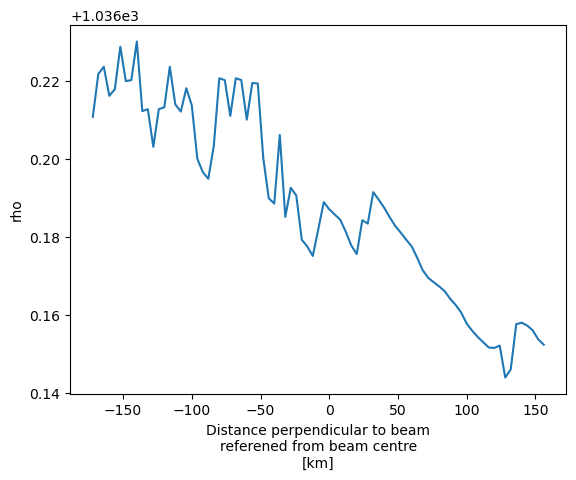

In [5]:
rho.isel(time = slice(0,200),yb = slice(7,None)).mean("time").mean("xb").mean("zl").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


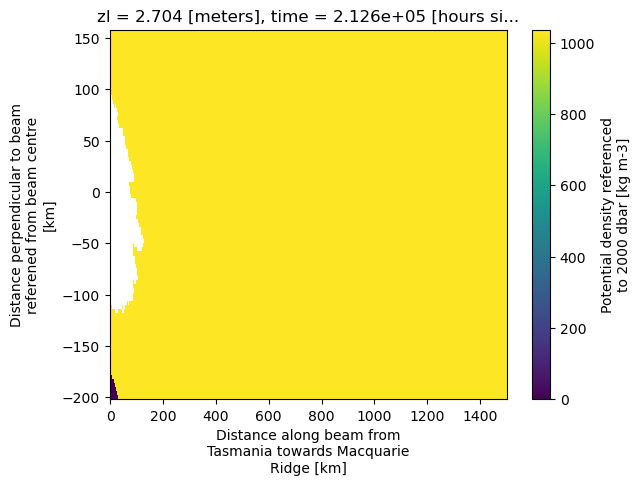

In [24]:
rho.isel(zl = 0,time = 5).plot()

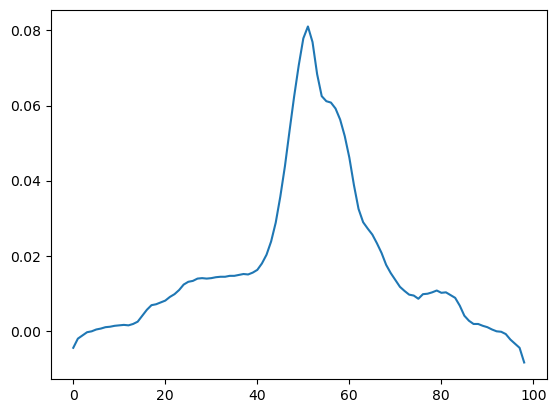

In [16]:
profile = rho.isel(time = slice(0,200),yb = slice(7,None)).mean("time").mean("xb").mean("yb")
drho = profile.values[1:] - profile.values[:-1]

plt.plot(drho)
## Make a new numpy array containing all the values of drho when they are greater than 0.005


In [28]:
new  = profile[1:].values[drho > 0.005]
new_rho2diag = xr.Dataset(
    {
        "nrho":(["nrho"],np.arange(len(new))),
        "rho2":(["nrho"],new)
        })
new_rho2diag

## encode all the variables as double
for var in new_rho2diag.variables:
    new_rho2diag[var].encoding["dtype"] = "float64"
## set units as kg m-3
new_rho2diag.rho2.attrs["units"] = "kg m-3"
new_rho2diag.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/synbath/diag_rho2.nc")